<a href="https://colab.research.google.com/github/vpapoglou/Machine-Learning-Auth/blob/main/%CE%95%CF%81%CE%B3%CE%B1%CF%83%CE%AF%CE%B1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Φόρτωση του Dataset

In [1]:
import pandas as pd

df = pd.read_csv('train.csv')

# Χωρισμός σε Train/Test σε 90/10% και bar plot

--- Πλήθος Target ανά Κλάση σε Train και Test Sets ---
|   target |   Train |   Test |
|---------:|--------:|-------:|
|        0 |    3907 |    435 |
|        1 |    2944 |    327 |


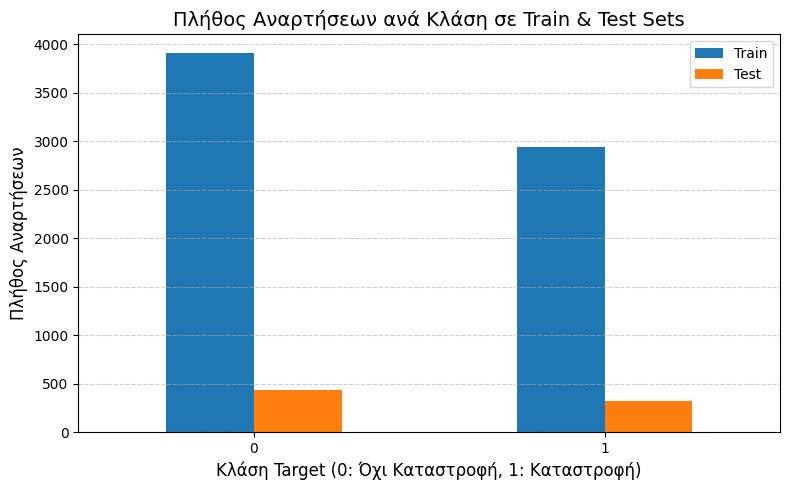

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Διαχωρισμός του dataset (90% Train, 10% Test)
# X = όλα τα χαρακτηριστικά εκτός του target
X = df.drop('target', axis=1)
# y = η μεταβλητή στόχος
y = df['target']

# Διαχωρισμός με stratify=y και random_state=0
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,  # 10% για το Test Set
    random_state=0,
    stratify=y
)

# Υπολογισμός πλήθους κλάσεων
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Δημιουργία DataFrame για το Plot
plot_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
})

# Δημιουργία Bar Plot
fig, ax = plt.subplots(figsize=(8, 5))
plot_df.plot(kind='bar', ax=ax, rot=0)

plt.title('Πλήθος Αναρτήσεων ανά Κλάση σε Train & Test Sets', fontsize=14)
plt.xlabel('Κλάση Target (0: Όχι Καταστροφή, 1: Καταστροφή)', fontsize=12)
plt.ylabel('Πλήθος Αναρτήσεων', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

print("--- Πλήθος Target ανά Κλάση σε Train και Test Sets ---")
print(plot_df.to_markdown())

To dataset δεν είναι απολύτως ισορροπημένο αλλά έχει έναν ικανοποιητικό βαθμό ισορροπίας.

# 2. Επεξεργασία δεδομένων

In [3]:
# Επεξεργασία (Drop, Fill, Combine)
for data in [X_train, X_test]:
    # Αφαίρεση "id", "location"
    data.drop(['id', 'location'], axis=1, inplace=True, errors='ignore')

    # Συμπλήρωση κενών με "null"
    data.fillna('null', inplace=True)

    # Δημιουργία στήλης "inputs"
    data['inputs'] = data['keyword'] + ' ' + data['text']

# Εμφάνιση των πρώτων γραμμών για επιβεβαίωση
print(X_train[['inputs']].head())

                                                 inputs
6669  threat Meek Mill responds to DrakeÛªs OVO Fes...
3940  flood survived the plague\nfloated the flood\n...
7217  weapons #Kick Hendrixonfire  @'=BLACKCATS= | B...
2234  deluge Vince McMahon once again a billionaire:...
4233  hazardous Is it possible to sneak into a hospi...


# 3. Καθαρισμός κειμένου

In [4]:
import re
import string

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replaceContraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                             (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def text_processed(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = removeEmoticons(text)
    text = replaceContraction(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)

    return text

# Εφαρμογή στα Train και Test sets
X_train['inputs'] = X_train['inputs'].apply(text_processed)
X_test['inputs'] = X_test['inputs'].apply(text_processed)

# Έλεγχος αποτελέσματος
print(X_train[['inputs']].head())

<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\)'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\)'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2215127341.py:12: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-2215127341.py:18: Sy

                                                 inputs
6669  threat Meek Mill responds to Drakes OVO Fest s...
3940  flood survived the plague\nfloated the flood\n...
7217  weapons Kick Hendrixonfire  @'=BLACKCATS= | BI...
2234  deluge Vince McMahon once again a billionaire ...
4233  hazardous Is it possible to sneak into a hospi...


Remove Unicode: Αφαίρεση μη-ASCII χαρακτήρων για απλοποίηση και ομαλοποίηση του κειμένου.

Replace URL: Αντικατάσταση των links με το token "url" καθώς το url ως κείμενο είναι απλά θόρυβος και δεν προσφέρει πληροφορία.

Remove Emoticons: Αφαίρεση emoticons που δεν προσθέτουν πληροφορία για καταστροφές.

Replace Contractions: Αντικατάσταση συντομογραφιών (π.χ. "can't" -> "cannot") για ομοιομορφία κειμένου.

Replace Multi-Punctuation: Αντικατάσταση πολλαπλών θαυμαστικών/ερωτηματικών με κείμενο όπως π.χ. "multiExclamation", καθώς η έντονη στίξη μπορεί να περιέχει κάποια χρήσιμη πληροφορία όπως π.χ. επείγον περιστατικό.

Remove Punctuation: Αφαίρεση των υπολοίπων σημείων στίξης για καθαρισμό του κειμένου.

# 4. Χωρισμός δεδομένων  σε inputs, targets (numpy arrays).


In [5]:
train_inputs = X_train['inputs'].values
train_targets = y_train.values

test_inputs = X_test['inputs'].values
test_targets = y_test.values

print(f"Train Inputs Shape: {train_inputs.shape}")
print(f"Train Targets Shape: {train_targets.shape}")
print(f"Test Inputs Shape: {test_inputs.shape}")
print(f"Test Targets Shape: {test_targets.shape}")

Train Inputs Shape: (6851,)
Train Targets Shape: (6851,)
Test Inputs Shape: (762,)
Test Targets Shape: (762,)


# 5. Υπολογισμός tf-idf (σημαντικότητα) κάθε λέξης

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Αρχικοποίηση TfidfVectorizer
vectorizer = TfidfVectorizer()

#fit_transform στο train set (μαθαίνει το λεξιλόγιο και μετασχηματίζει)
train_inputs_tfidf = vectorizer.fit_transform(train_inputs)

#transform στο test set (χρησιμοποιεί το ίδιο λεξιλόγιο)
test_inputs_tfidf = vectorizer.transform(test_inputs)

print(f"Train TF-IDF Shape: {train_inputs_tfidf.shape}")
print(f"Test TF-IDF Shape: {test_inputs_tfidf.shape}")

Train TF-IDF Shape: (6851, 16280)
Test TF-IDF Shape: (762, 16280)


#6. Εκπαίδευση ταξινομητή SVM με linear Kernel & Μετρικές

In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Εκπαίδευση (Linear Kernel)
svc = LinearSVC(random_state=0)
svc.fit(train_inputs_tfidf, train_targets)

# Προβλέψεις
y_train_pred = svc.predict(train_inputs_tfidf)
y_test_pred = svc.predict(test_inputs_tfidf)

# Εκτύπωση Μετρικών
print("--- Test Set Metrics ---")
print(f"Accuracy:  {accuracy_score(test_targets, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(test_targets, y_test_pred):.4f}")
print(f"Precision: {precision_score(test_targets, y_test_pred):.4f}")
print(f"Recall:    {recall_score(test_targets, y_test_pred):.4f}")

--- Test Set Metrics ---
Accuracy:  0.7979
F1 Score:  0.7586
Precision: 0.7781
Recall:    0.7401


Αν πρέπει να διαλέξουμε μία για την αξιολόγηση της ποιότητας του μοντέλου, η Recall θα ήταν η πιο σημαντική καθώς το False Positive ιεραρχείται ως χαμηλότερος κίνδυνος σε σχέση με το False Negative που μπορεί να έχει κόστος ανθρώπινων ζωών. Αν όμως θέλουμε και να μην απαξιωθεί το σύστημα και υπάρχει σπατάλη πόρων, θα μπορούσαμε να χρησιμοποιήσουμε το F1-score ως μέτρο της συνολικής ισορροπίας.

# 7. Μετασχηματισμός PCA στα δεδομένα και εκπαίδευση με LinearSVC και SVC με RBF kernel

In [8]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# PCA (95% διακύμανση)
# Το PCA θέλει dense πίνακα(αποθηκεύει και τα μηδενικά), οπότε μετατρέπουμε τον sparce πίνακα(αποθηκεύει μόνο τα μη μηδενικά) του TF-IDF
X_train_dense = train_inputs_tfidf.toarray()
X_test_dense = test_inputs_tfidf.toarray()

pca = PCA(n_components=0.95, random_state=0)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

print(f"Διαστάσεις πριν: {X_train_dense.shape[1]}, Μετά (PCA 95%): {X_train_pca.shape[1]}")

# LinearSVC
lsvc = LinearSVC(random_state=0)
lsvc.fit(X_train_pca, train_targets)
y_pred_linear = lsvc.predict(X_test_pca)

# SVC (RBF Kernel)
rbf_svc = SVC(kernel='rbf', random_state=0)
rbf_svc.fit(X_train_pca, train_targets)
y_pred_rbf = rbf_svc.predict(X_test_pca)

Διαστάσεις πριν: 16280, Μετά (PCA 95%): 4095


# 8. Αλλαγή παραμέτρου σε "auto" και επανεκπαίδευση του SVC

Από Documentation:
*   if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
*   if 'auto', uses 1 / n_features



Εκπαίδευση SVC (RBF, gamma='auto') στα PCA δεδομένα...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


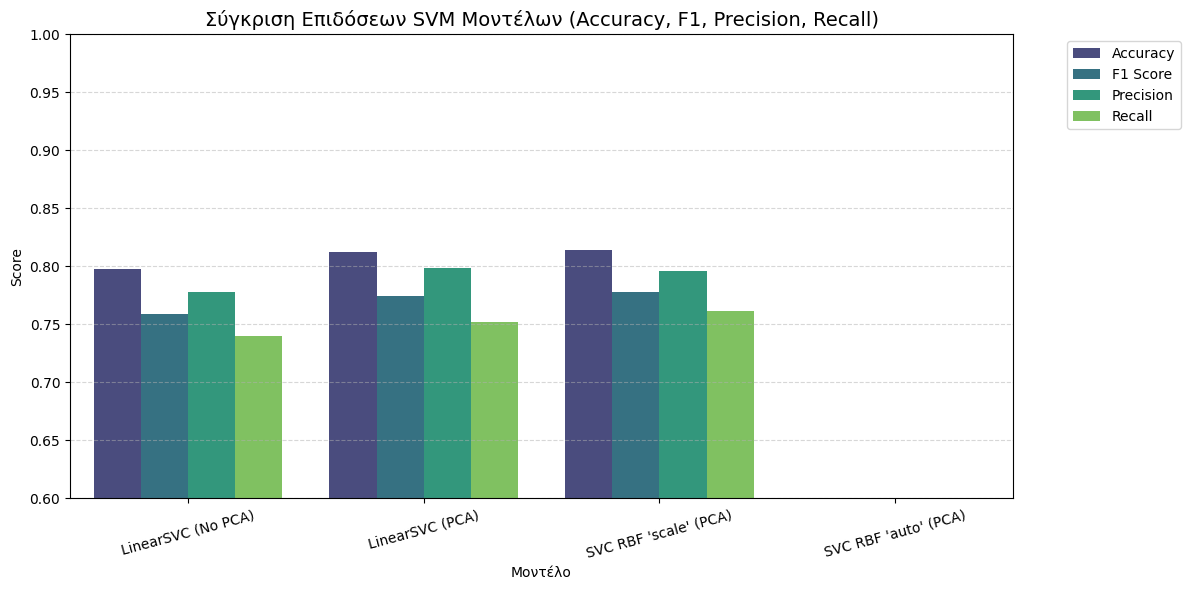


--- Πίνακας Αποτελεσμάτων ---
| Model                 |   Accuracy |   F1 Score |   Precision |   Recall |
|:----------------------|-----------:|-----------:|------------:|---------:|
| LinearSVC (No PCA)    |     0.7979 |     0.7586 |      0.7781 |   0.7401 |
| LinearSVC (PCA)       |     0.8123 |     0.7748 |      0.7987 |   0.7523 |
| SVC RBF 'scale' (PCA) |     0.8136 |     0.7781 |      0.7955 |   0.7615 |
| SVC RBF 'auto' (PCA)  |     0.5709 |     0.0000 |      0.0000 |   0.0000 |


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Εκπαίδευση του νέου μοντέλου (RBF με gamma='auto')
print("Εκπαίδευση SVC (RBF, gamma='auto') στα PCA δεδομένα...")
svc_auto = SVC(kernel='rbf', gamma='auto', random_state=0)
svc_auto.fit(X_train_pca, train_targets)
preds_auto = svc_auto.predict(X_test_pca)

# Συλλογή αποτελεσμάτων από όλα τα μοντέλα

# Μοντέλο 1: LinearSVC (No PCA)
lsvc_no_pca = LinearSVC(random_state=0)
lsvc_no_pca.fit(train_inputs_tfidf, train_targets)
p1 = lsvc_no_pca.predict(test_inputs_tfidf)

# Μοντέλο 2: LinearSVC (PCA)
lsvc_pca = LinearSVC(random_state=0)
lsvc_pca.fit(X_train_pca, train_targets)
p2 = lsvc_pca.predict(X_test_pca)

# Μοντέλο 3: SVC RBF 'scale' (PCA)
svc_scale = SVC(kernel='rbf', gamma='scale', random_state=0)
svc_scale.fit(X_train_pca, train_targets)
p3 = svc_scale.predict(X_test_pca)

# Μοντέλο 4: SVC RBF 'auto' (PCA) -> preds_auto (p4)
p4 = preds_auto

# Λίστα με τα μοντέλα και τις προβλέψεις τους
models_data = [
    ("LinearSVC (No PCA)", p1),
    ("LinearSVC (PCA)", p2),
    ("SVC RBF 'scale' (PCA)", p3),
    ("SVC RBF 'auto' (PCA)", p4)
]

# Υπολογισμός μετρικών
results = []
for name, preds in models_data:
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(test_targets, preds),
        "F1 Score": f1_score(test_targets, preds),
        "Precision": precision_score(test_targets, preds),
        "Recall": recall_score(test_targets, preds)
    })

df_results = pd.DataFrame(results)

# Δημιουργία Bar Plot
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis")

plt.title("Σύγκριση Επιδόσεων SVM Μοντέλων (Accuracy, F1, Precision, Recall)", fontsize=14)
plt.ylim(0.6, 1.0) # Zoom για να φανούν οι διαφορές
plt.ylabel("Score")
plt.xlabel("Μοντέλο")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Εκτύπωση πίνακα για ακριβή νούμερα
print("\n--- Πίνακας Αποτελεσμάτων ---")
print(df_results.set_index("Model").to_markdown(floatfmt=".4f"))

# 9. Επανάληψη της ερώτησης 6 (πριν εφαρμοστεί ο μετασχηματισμός PCA) με τη χρήση Gaussian Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Μετατροπή των sparse πινάκων TF-IDF σε dense
# Τα train_inputs_tfidf και test_inputs_tfidf υπάρχουν από την ερώτηση 6
X_train_dense = train_inputs_tfidf.toarray()
X_test_dense = test_inputs_tfidf.toarray()

# Εκπαίδευση Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_dense, train_targets)

# Προβλέψεις
train_pred = gnb.predict(X_train_dense)
test_pred = gnb.predict(X_test_dense)

# Υπολογισμός και Εμφάνιση Μετρικών
metrics_data = {
    'Set': ['Train', 'Test'],
    'Accuracy': [accuracy_score(train_targets, train_pred), accuracy_score(test_targets, test_pred)],
    'F1 Score': [f1_score(train_targets, train_pred), f1_score(test_targets, test_pred)],
    'Precision': [precision_score(train_targets, train_pred), precision_score(test_targets, test_pred)],
    'Recall': [recall_score(train_targets, train_pred), recall_score(test_targets, test_pred)]
}

print(pd.DataFrame(metrics_data).to_markdown(index=False, floatfmt=".4f"))

| Set   |   Accuracy |   F1 Score |   Precision |   Recall |
|:------|-----------:|-----------:|------------:|---------:|
| Train |     0.9183 |     0.9132 |      0.8402 |   1.0000 |
| Test  |     0.6273 |     0.6459 |      0.5453 |   0.7920 |
